In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from unidecode import unidecode
# Gensim
import gensim
from ast import literal_eval
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# nltk for stop words
import nltk
from nltk.corpus import stopwords

C:\Users\FM\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\FM\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\FM\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# traemos desde Textools, reemplazando sent_to_words

def to_unicode(column):
    if isinstance(column, list):
        column = pd.Series(column)
        column = column.apply(lambda x: unidecode(str(x)).lower())
        return column.values[0]
    if isinstance(column, pd.Series):
        column = column.apply(lambda x: unidecode(str(x)).lower())
        return column
    if isinstance(column, pd.DataFrame):
        for c in column.columns:
             column[c] = column[c].apply(lambda x: unidecode(str(x).lower()))
        return column
    return column

def tokenize(column):
    """ Tokenize a given column
    Args:
        column ([Serie]): a pandas column
    Return:
        a pandas column with tockens lists
    """
    def step(cell):
        # Remove special characters
        cell = unidecode(str(cell))
        # Lowercase
        cell = cell.lower()
        # Extract only words
        rfilter = r'[a-z]+'
        finds = re.findall(rfilter, cell)
        # Remove one-letters words
        finds = [f for f in finds if len(f)>1]
        # Remove stop words
        finds = [f for f in finds \
        if f not in stopwords.words('spanish')]
        if finds == ['nr'] or finds == [] or finds==['nan']:
            finds = 'NR'
        return finds

    assert isinstance(column, pd.Series), \
    'Column should be a pandas Serie. {} was received instead'.format(type(column))

    column = column.apply(lambda x: step(x))
    return column

In [3]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) # deacc=True removes punctuations
        yield(sent)          
        
        
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out  

In [4]:
# NLTK Stop words
stop_words = stopwords.words('spanish')

# Spacy fro NLP
# Initialize spacy 'es' model, keeping only tagger component (for efficiency)
# python3 -m spacy download 

#nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])
#nlp = spacy.load('es_core_news_sm')
#nlp = spacy.load('es_core_news_lg')
nlp = spacy.load('es_dep_news_trf', disable=['parser', 'ner'])

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [5]:
#lectura de Archivo
df = pd.read_excel (r'input\compromisos.xlsx')
print(df.Compromiso.unique())
df.head()

['1 y 2: Estudiar más, para tener mejores trabajos y así las personas que ganan el sueldo mínimo sean muy pocas y eso ayuda a que sea más fácil subirlo'
 'NUEVA CONSTITUCION PARA CHILE CON LA PARTICIPACION ACTIVA DE TODOS LOS CHILENOS.'
 'Involucrarme en dar mis opiniones y' ...
 '39.\tPrometo no ser Yuta cuando grande.'
 '40.\tPrometo ser fiel y leal a mi país.'
 '41.\tPrometo cumplir y sobrepasar mis metas']


,ORDEN,N,Compromiso
0,1,1,"1 y 2: Estudiar más, para tener mejores trabaj..."
1,2,1,NUEVA CONSTITUCION PARA CHILE CON LA PARTICIPA...
2,3,1,Involucrarme en dar mis opiniones y
3,5,1,Que el estado sea quien responda a las inquiet...
4,6,1,"Realizar un nuevo diálogo, con mas tiempo."


In [18]:
# Convert to list
data = df.Compromiso.values.tolist()

# otra opción de limpieza
#data_words = list(sent_to_words(data))
#print(data_words[:10])

# Opción de limpieza tomada
data_words = list(tokenize(to_unicode(df.Compromiso)))
print(data_words[:10])

[['estudiar', 'mas', 'tener', 'mejores', 'trabajos', 'asi', 'personas', 'ganan', 'sueldo', 'minimo', 'pocas', 'ayuda', 'mas', 'facil', 'subirlo'], ['nueva', 'constitucion', 'chile', 'participacion', 'activa', 'chilenos'], ['involucrarme', 'dar', 'opiniones'], ['responda', 'inquietudes', 'detectado', 'actual', 'crisis', 'social', 'vive', 'pais'], ['realizar', 'nuevo', 'dialogo', 'mas', 'tiempo'], ['continuamente', 'iran', 'generando', 'espacios', 'permitan', 'ninos', 'ninas', 'puedan', 'expresar', 'necesidades', 'potenciando', 'ademas', 'participacion', 'mejoras', 'pretenden', 'llevar', 'cabo'], ['traspasar', 'informacion', 'ministerio', 'desarrollo', 'social', 'seguir', 'participando'], ['traspasar', 'informacion', 'ministerio', 'desarrollo', 'social', 'seguir', 'participando'], ['tratar', 'dialogar', 'solucionar', 'conflictos'], ['participacion', 'activa', 'actividades', 'destinadas', 'edade']]


In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=30) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=30)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram) 
print(trigram_mod[bigram_mod[data_words[0]]])

['estudiar', 'mas', 'tener', 'mejores', 'trabajos', 'asi', 'personas', 'ganan', 'sueldo', 'minimo', 'pocas', 'ayuda', 'mas', 'facil', 'subirlo']


In [20]:
data_lemmatized=process_words(data_words)     
print(data_lemmatized[:10])

[['estudiar', 'tener', 'mejor', 'trabajo', 'asi', 'persona', 'ganar', 'sueldo', 'minimo', 'ayuda', 'mas', 'facil', 'subir'], ['chile', 'chileno'], ['involucrar', 'dar', 'opinión'], ['responder', 'inquietud', 'detectar', 'actual', 'crisis_social', 'vivir', 'pais'], ['realizar', 'nuevo', 'dialogo', 'mas', 'tiempo'], ['continuamente', 'iran', 'generar', 'espacio', 'permitir', 'ninos_nina', 'necesidad', 'potenciar', 'ademas', 'participacion', 'mejora', 'pretender', 'llevar', 'cabo'], ['traspasar', 'informacion', 'ministerio', 'desarrollo', 'social'], ['traspasar', 'informacion', 'ministerio', 'desarrollo', 'social'], ['tratar', 'dialogar', 'solucionar', 'conflicto'], ['actividad', 'destinado', 'edade']]


In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[('asi', 1),
  ('ayuda', 1),
  ('estudiar', 1),
  ('facil', 1),
  ('ganar', 1),
  ('mas', 1),
  ('mejor', 1),
  ('minimo', 1),
  ('persona', 1),
  ('subir', 1),
  ('sueldo', 1),
  ('tener', 1),
  ('trabajo', 1)],
 [('chile', 1), ('chileno', 1)],
 [('dar', 1), ('involucrar', 1), ('opinión', 1)],
 [('actual', 1),
  ('crisis_social', 1),
  ('detectar', 1),
  ('inquietud', 1),
  ('pais', 1),
  ('responder', 1),
  ('vivir', 1)],
 [('mas', 1), ('dialogo', 1), ('nuevo', 1), ('realizar', 1), ('tiempo', 1)]]

# Build LDA model

In [30]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=128,
                                           passes=10,
                                           alpha='auto',
                                           eta='auto',
                                           decay=0.5, 
#                                           distributed=True, 
#                                           alpha=0.01,
#                                           eta=0.1, 
                                           per_word_topics=True)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.091*"comprometer" + 0.040*"mejor" + 0.031*"trabajo" + 0.022*"demanda" + '
  '0.020*"respetuoso" + 0.018*"escuela" + 0.018*"asi" + 0.017*"subir" + '
  '0.017*"ninos_nina" + 0.016*"continuar"'),
 (1,
  '0.179*"cuidar" + 0.032*"comunidad" + 0.028*"reciclar" + 0.028*"pelear" + '
  '0.024*"planet" + 0.023*"violencia" + 0.022*"expresar" + 0.021*"futuro" + '
  '0.020*"cumplir" + 0.017*"dar_conocer"'),
 (2,
  '0.090*"espacio" + 0.045*"participacion" + 0.043*"mayor" + 0.030*"mantener" '
  '+ 0.030*"generar" + 0.027*"joven" + 0.018*"calle" + 0.016*"evitar" + '
  '0.016*"ambito" + 0.016*"publico"'),
 (3,
  '0.122*"mas" + 0.033*"nna" + 0.027*"social" + 0.024*"pasar" + 0.018*"comuna" '
  '+ 0.018*"cita_textual" + 0.016*"tema" + 0.015*"tener" + 0.015*"cabildo" + '
  '0.015*"manera"'),
 (4,
  '0.067*"ayudar" + 0.059*"persona" + 0.043*"opinion" + 0.040*"estudiar" + '
  '0.033*"dar" + 0.031*"siempre" + 0.024*"companero" + 0.022*"opinión" + '
  '0.020*"discriminar" + 0.017*"respeto"'),
 (5,
  

In [31]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.617769705695155

Coherence Score:  0.5929405669270682


# Visualize the topics

In [32]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.179083  0.137622       1        1  13.525932
3      0.085973 -0.120412       2        1  12.953298
6     -0.235951 -0.061928       3        1  11.752636
7     -0.166977  0.217737       4        1  10.537867
1      0.000852 -0.112776       5        1   9.200852
4     -0.028852 -0.135872       6        1   9.176936
0      0.031006  0.137215       7        1   8.734442
5      0.070324 -0.021785       8        1   8.387784
9     -0.037965 -0.035488       9        1   8.020896
2      0.102507 -0.004313      10        1   7.709357, topic_info=             Term        Freq       Total Category  logprob  loglift
133        cuidar  136.000000  136.000000  Default  30.0000  30.0000
5             mas  130.000000  130.000000  Default  29.0000  29.0000
167   comprometer  110.000000  110.000000  Default  28.0000  28.0000
32        espacio   58.000000   58.000000  Default  27.0000  27.0000
117    participar   69.000000   69.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1489         robo    3.345342    4.179950  Topic10  -5.2445   2.3400
144         mayor   27.527633   43.593981  Topic10  -3.1369   2.1030
128         joven   17.079362   26.159877  Topic10  -3.6142   2.1364
33        generar   19.205368   51.760878  Topic10  -3.4969   1.5713
143     instancia    4.585426   33.528039  Topic10  -4.9292   0.5732

[363 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1421      6  0.884476   abuelito
1729      4  0.878905     abusar
264       3  0.951472    acceder
303       9  0.893913     acción
1372      9  0.904646    aceptar
...     ...       ...        ...
432       5  0.944389  violencia
24        9  0.937533      vivir
608       1  0.873294       vivo
763       1  0.924230      votar
696       1  0.972192       voto

[350 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 7, 8, 2, 5, 1, 6, 10, 3])

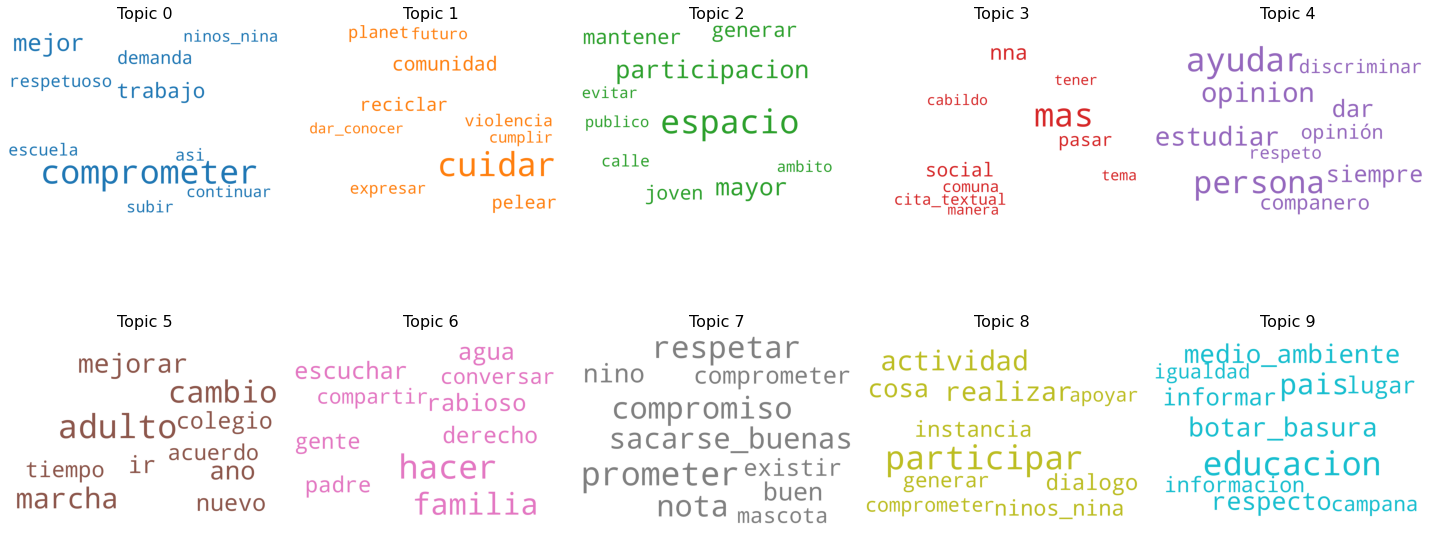

In [33]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2,5, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Crear Tablas

In [43]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # 0 => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

data_ready=data_lemmatized
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
pd.DataFrame(df_dominant_topic, columns=['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']).to_excel("temp/nna_compro"+ str(lda_model.num_topics) +".xlsx")
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.5769,"comprometer, mejor, trabajo, demanda, respetuoso, escuela, asi, subir, ninos_nina, continuar","[estudiar, tener, mejor, trabajo, asi, persona, ganar, sueldo, minimo, ayuda, mas, facil, subir]"
1,1,5.0,0.4449,"adulto, cambio, marcha, mejorar, ano, ir, nuevo, colegio, tiempo, acuerdo","[chile, chileno]"
2,2,4.0,0.5467,"ayudar, persona, opinion, estudiar, dar, siempre, companero, opinión, discriminar, respeto","[involucrar, dar, opinión]"
3,3,9.0,0.7199,"educacion, pais, botar_basura, medio_ambiente, respecto, informar, lugar, informacion, campana, ...","[responder, inquietud, detectar, actual, crisis_social, vivir, pais]"
4,4,5.0,0.2924,"adulto, cambio, marcha, mejorar, ano, ir, nuevo, colegio, tiempo, acuerdo","[realizar, nuevo, dialogo, mas, tiempo]"
5,5,2.0,0.7258,"espacio, participacion, mayor, mantener, generar, joven, calle, evitar, ambito, publico","[continuamente, iran, generar, espacio, permitir, ninos_nina, necesidad, potenciar, ademas, part..."
6,6,9.0,0.6464,"educacion, pais, botar_basura, medio_ambiente, respecto, informar, lugar, informacion, campana, ...","[traspasar, informacion, ministerio, desarrollo, social]"
7,7,9.0,0.6464,"educacion, pais, botar_basura, medio_ambiente, respecto, informar, lugar, informacion, campana, ...","[traspasar, informacion, ministerio, desarrollo, social]"
8,8,3.0,0.1976,"mas, nna, social, pasar, comuna, cita_textual, tema, tener, cabildo, manera","[tratar, dialogar, solucionar, conflicto]"
9,9,3.0,0.5046,"mas, nna, social, pasar, comuna, cita_textual, tema, tener, cabildo, manera","[actividad, destinado, edade]"


In [44]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
pd.DataFrame(sent_topics_sorteddf_mallet, columns=['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]).to_excel("temp/nna_compro"+ str(lda_model.num_topics) +"_dts.xlsx")
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.7092,"comprometer, mejor, trabajo, demanda, respetuoso, escuela, asi, subir, ninos_nina, continuar","[estudiante, comprender, resolucion, satisfaccion, necesidad, bien, corresponder, tarea, necesar..."
1,1.0,0.6990,"cuidar, comunidad, reciclar, pelear, planet, violencia, expresar, futuro, cumplir, dar_conocer","[cuidar, arbol, planeta, reciclar, cuidar, medio_ambient]"
2,2.0,0.7258,"espacio, participacion, mayor, mantener, generar, joven, calle, evitar, ambito, publico","[continuamente, iran, generar, espacio, permitir, ninos_nina, necesidad, potenciar, ademas, part..."
3,3.0,0.7200,"mas, nna, social, pasar, comuna, cita_textual, tema, tener, cabildo, manera","[seguir_realizar, actividad, considerar, opinión, nino, tematica, relevante]"
4,4.0,0.6976,"ayudar, persona, opinion, estudiar, dar, siempre, companero, opinión, discriminar, respeto","[valiente, luchar_derechos, humanos, faltar, respeto, demas]"
5,5.0,0.6801,"adulto, cambio, marcha, mejorar, ano, ir, nuevo, colegio, tiempo, acuerdo","[visitar, tiempo, repetir, ejercicio, comparar, tiempo, factor, externo, influir, bienestar, nor..."
6,6.0,0.6795,"hacer, familia, rabioso, escuchar, agua, derecho, padre, gente, conversar, compartir","[acordar, realizar, gestión, ninos_nina, acceder, ejemplo, piscina, municipal, proximo, reunion,..."
7,7.0,0.8314,"prometer, respetar, compromiso, nota, sacarse_buenas, nino, buen, comprometer, existir, mascota","[compromiso, adquirido, principalmente, organizando, levantar, idea, posteriormente, entregar, i..."
8,8.0,0.7353,"participar, actividad, realizar, cosa, dialogo, instancia, ninos_nina, generar, comprometer, apoyar","[realizacion, jornada, periodica, dialogo, ninos_nina, adolescente, joven, seguir, profundizar, ..."
9,9.0,0.7199,"educacion, pais, botar_basura, medio_ambiente, respecto, informar, lugar, informacion, campana, ...","[responder, inquietud, detectar, actual, crisis_social, vivir, pais]"


# Más Gráficos

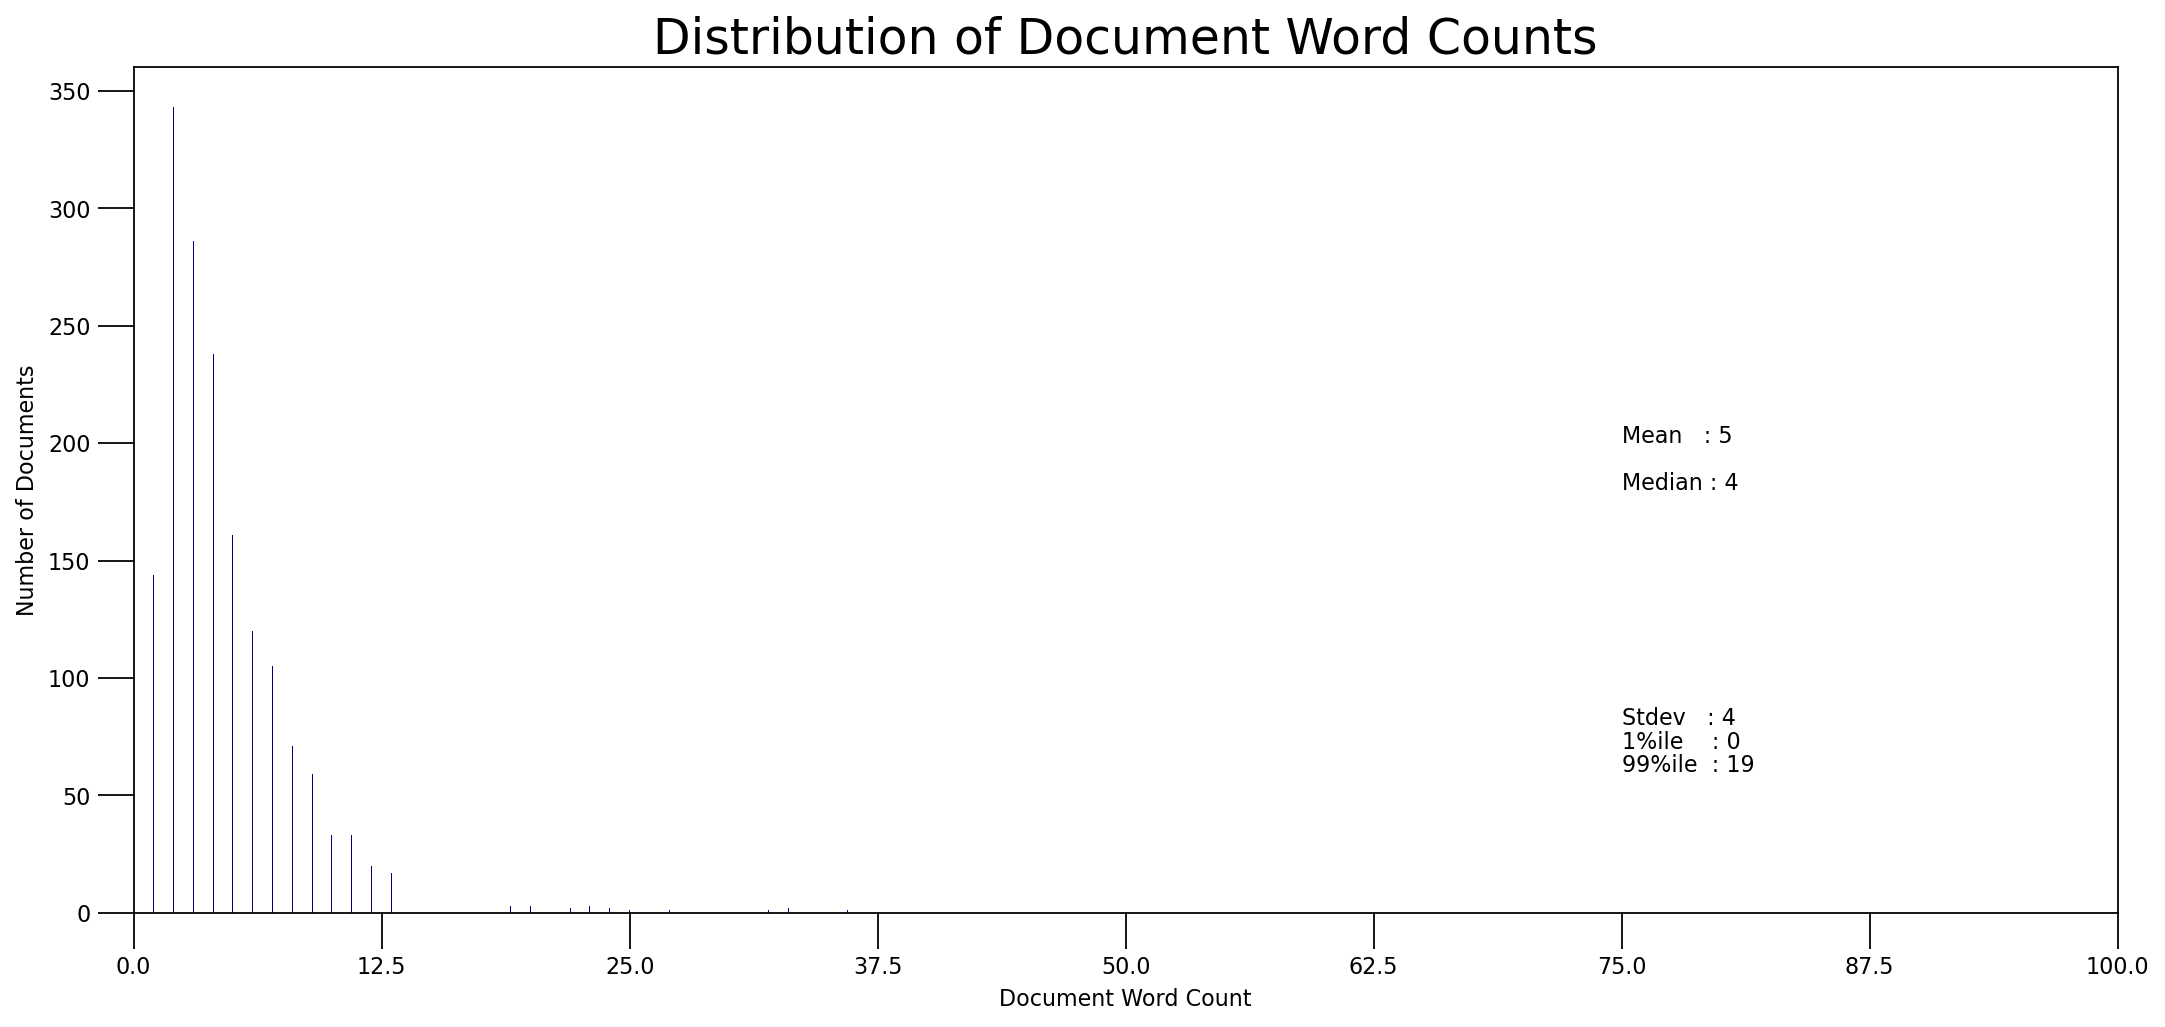

In [37]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(75, 200, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(75,  180, "Median : " + str(round(np.median(doc_lens))))
plt.text(75,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(75,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(75,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 100), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,100,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

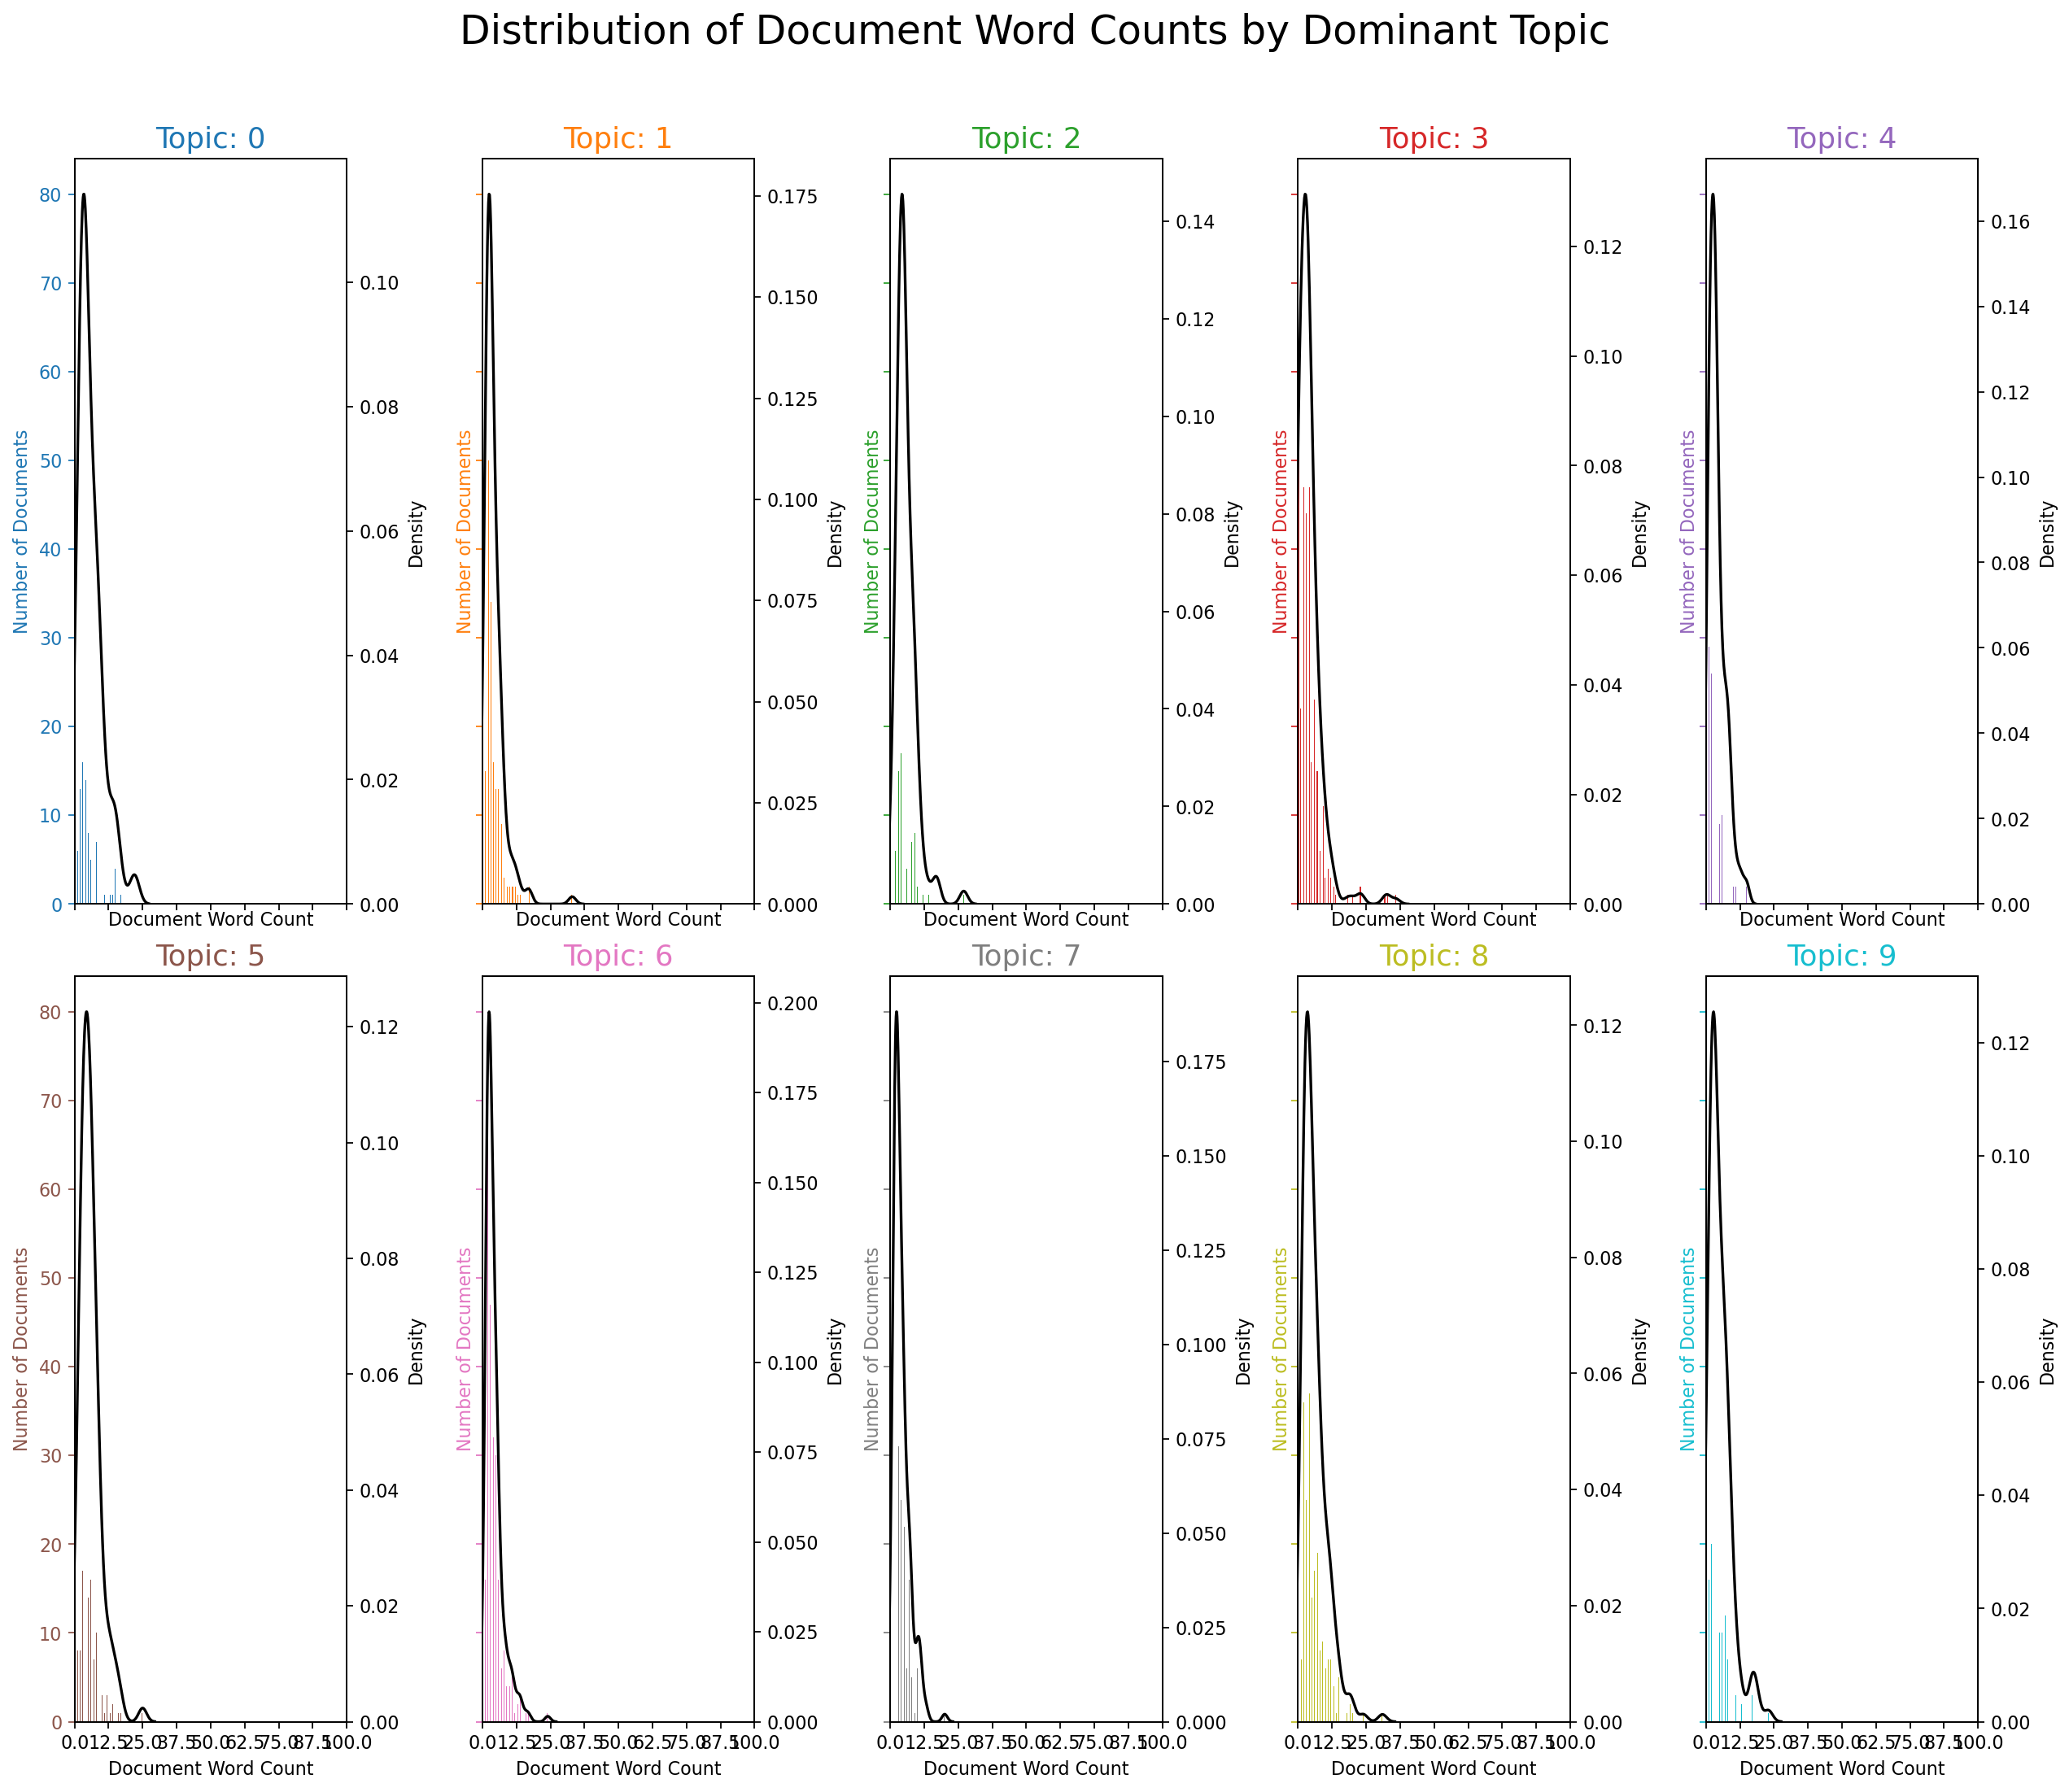

In [38]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,5,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 100), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,100,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

C:\Users\FM\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\FM\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\FM\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\FM\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\FM\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\FM\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\FM\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\FM\A

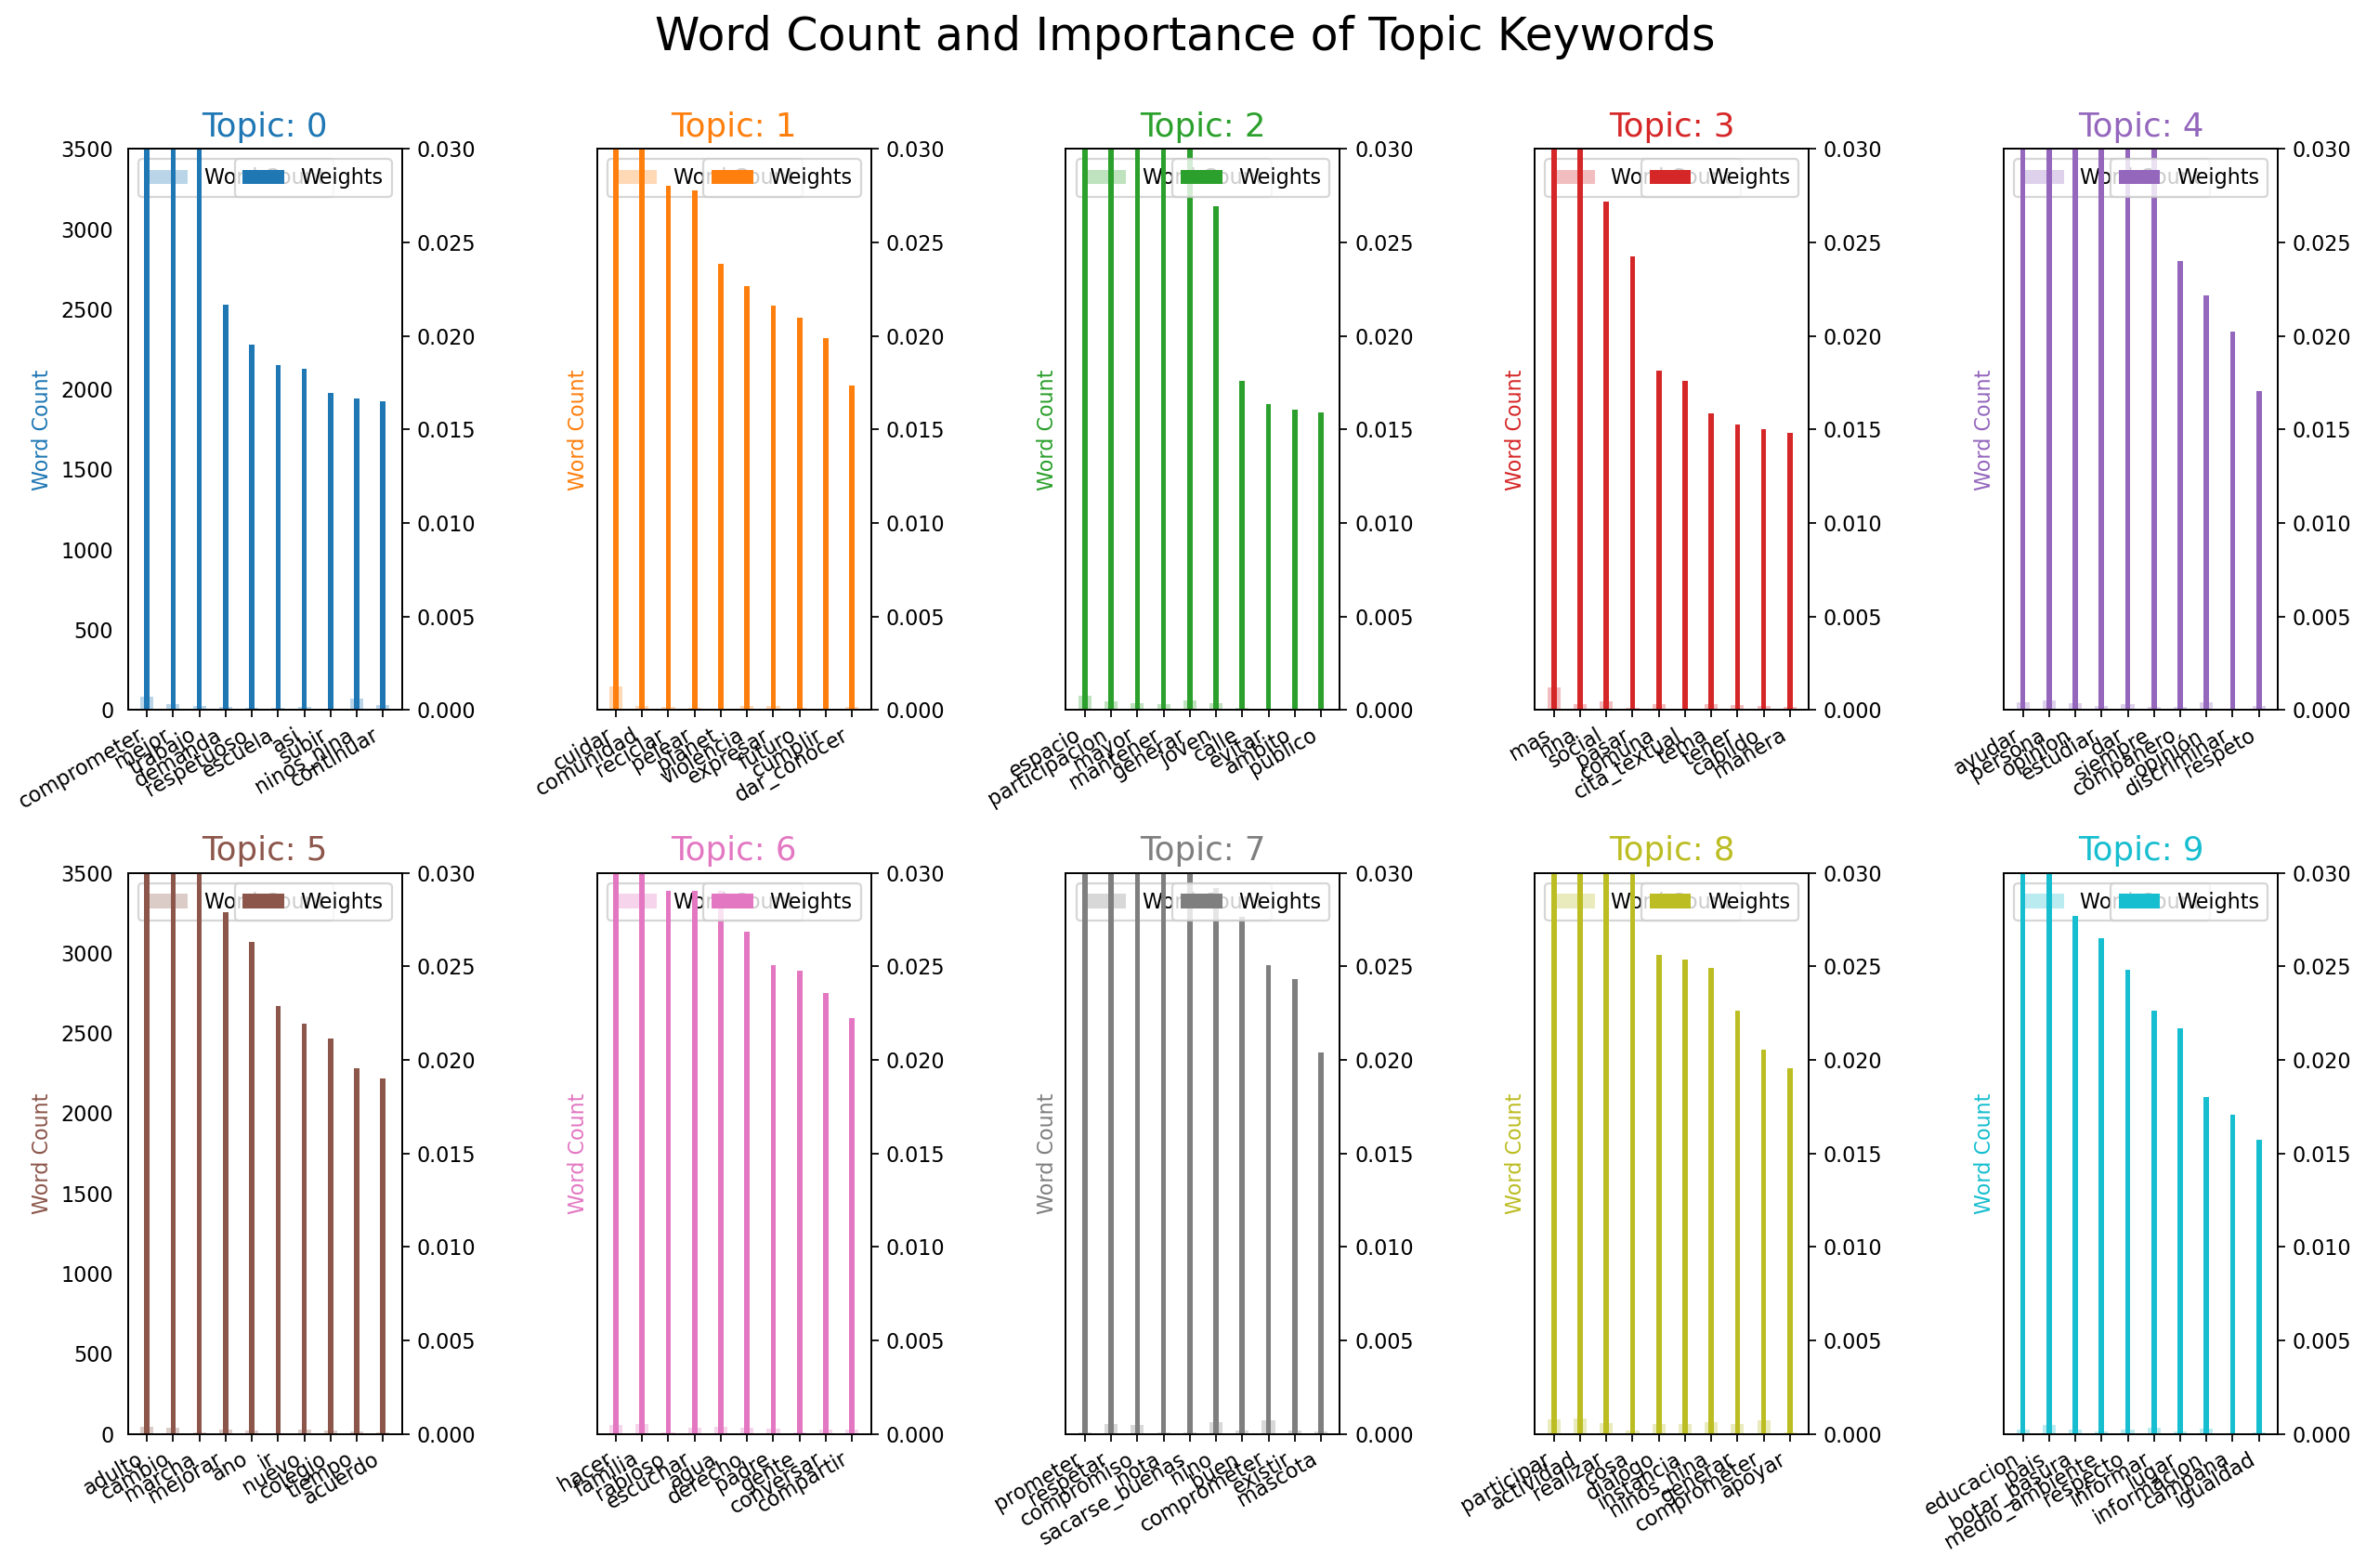

In [39]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 5, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

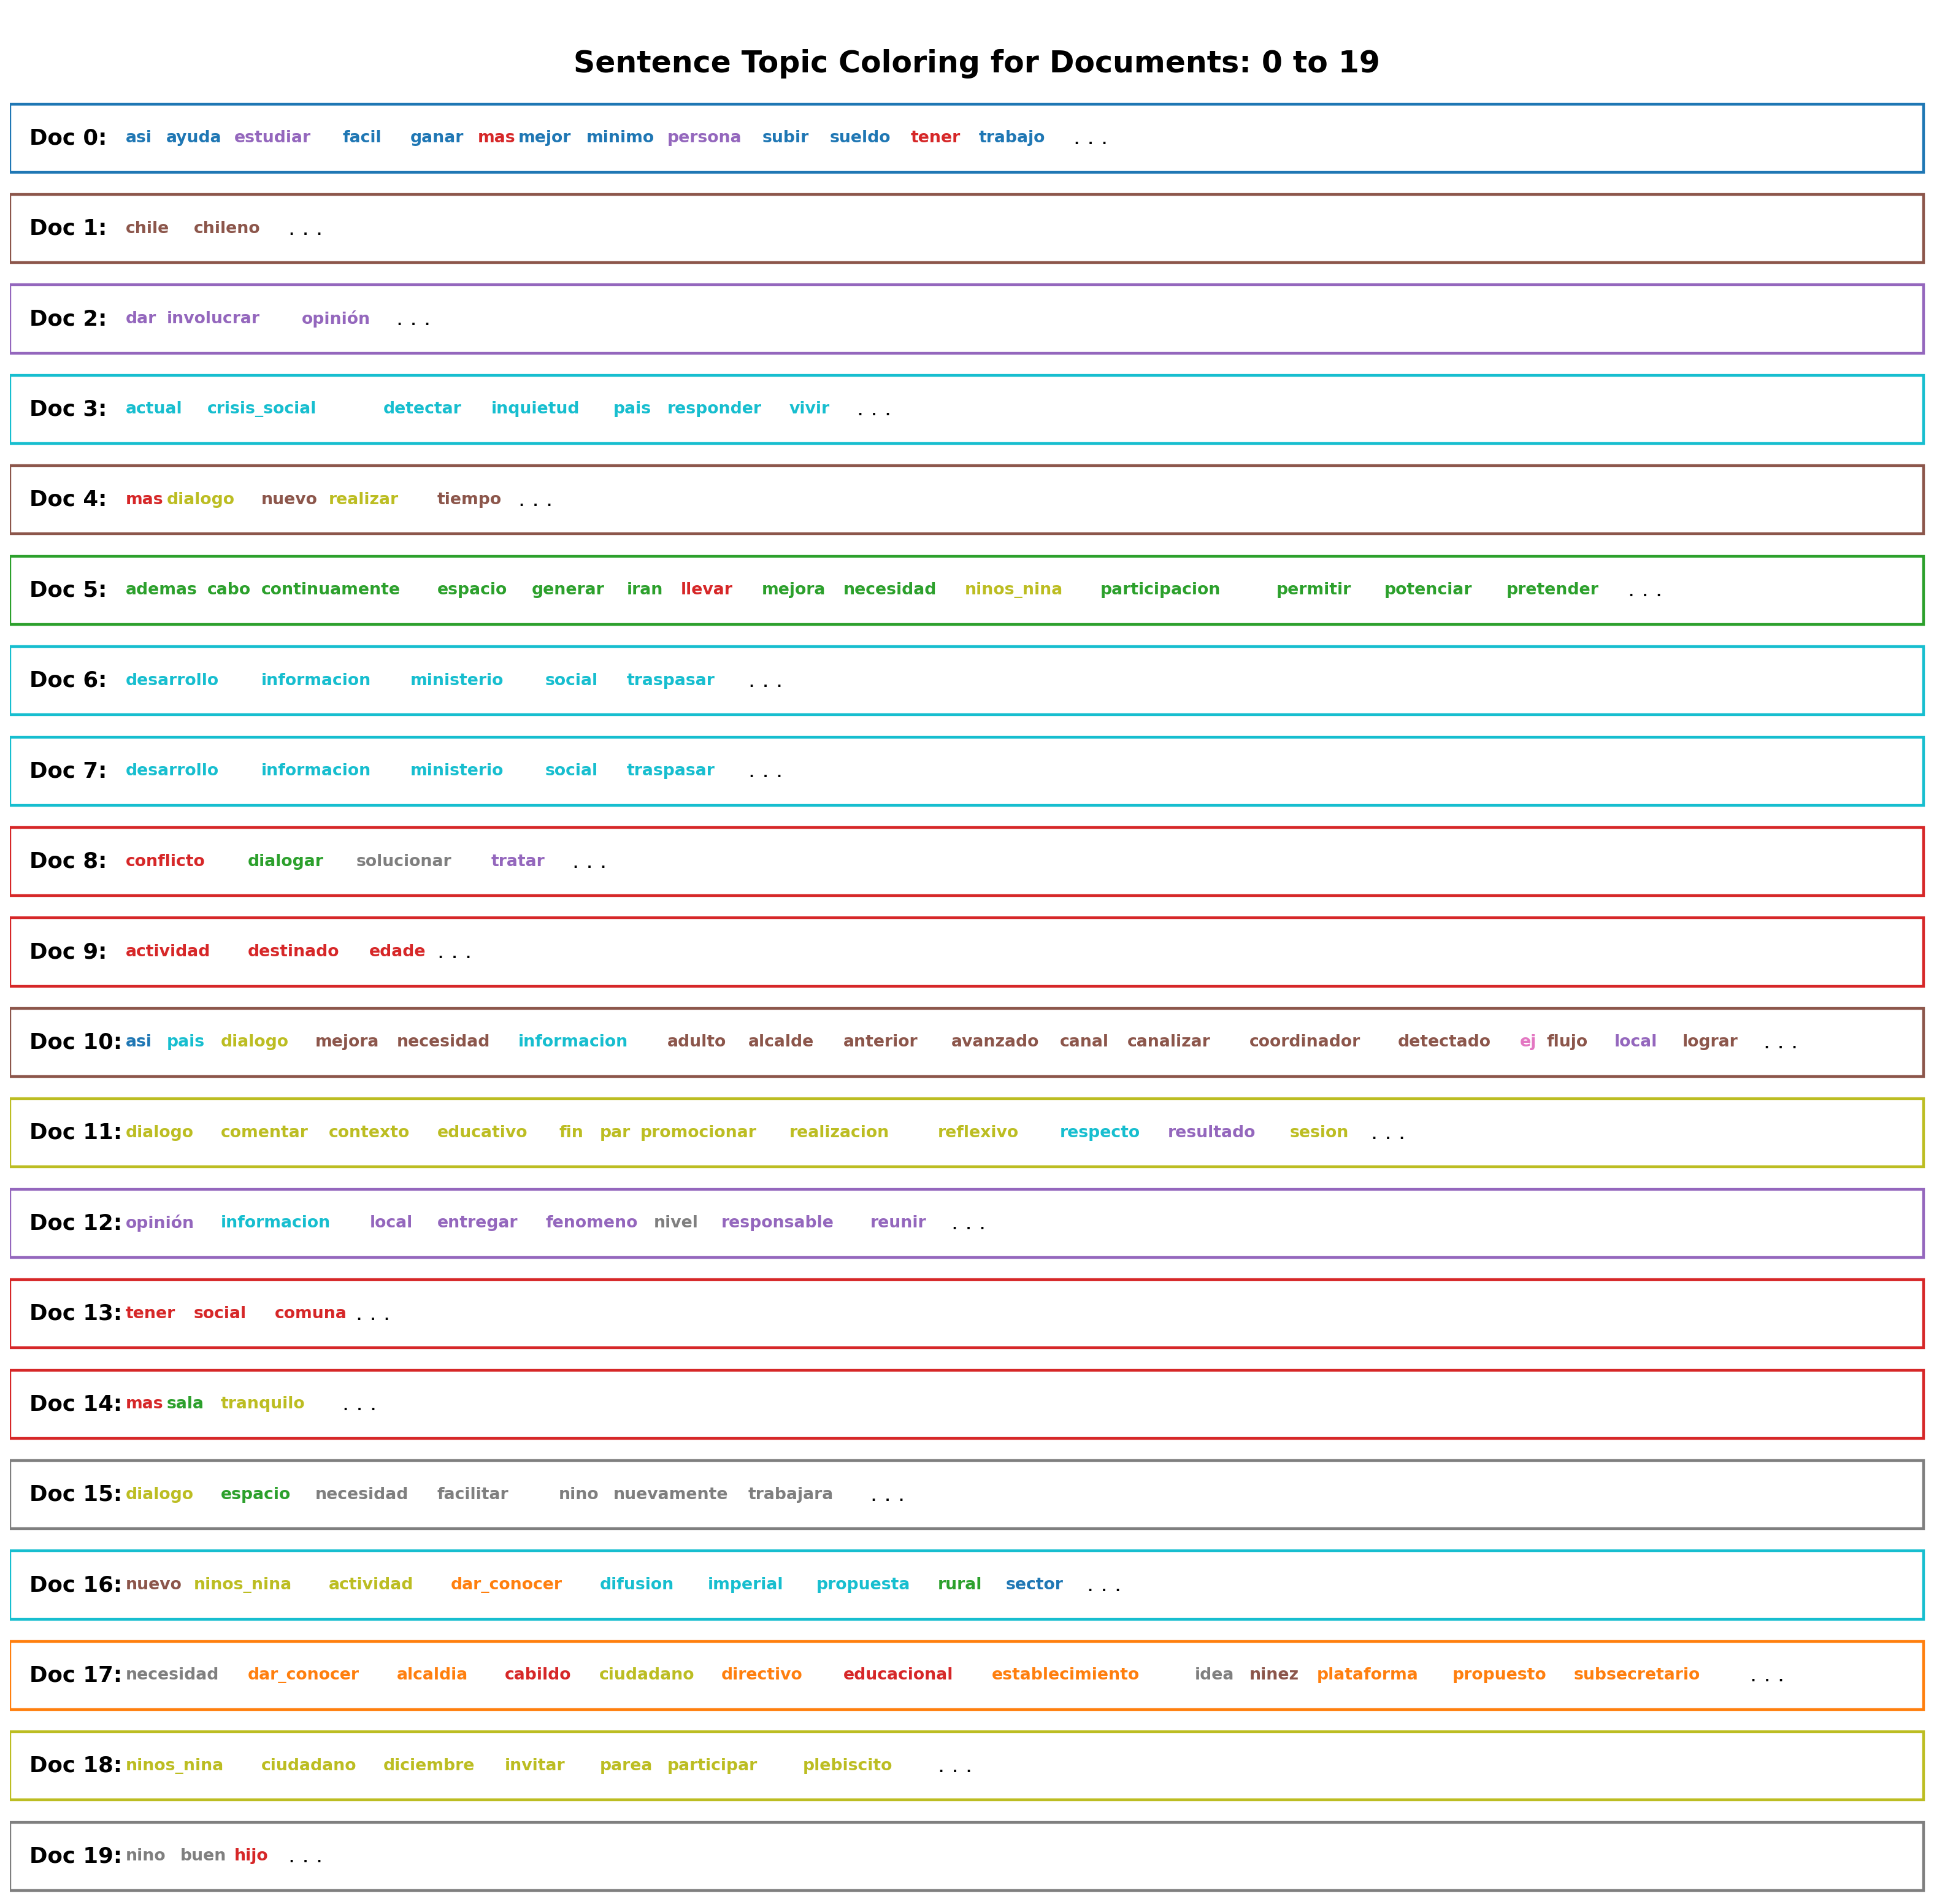

In [40]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 21):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 18:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=12, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .007 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()  

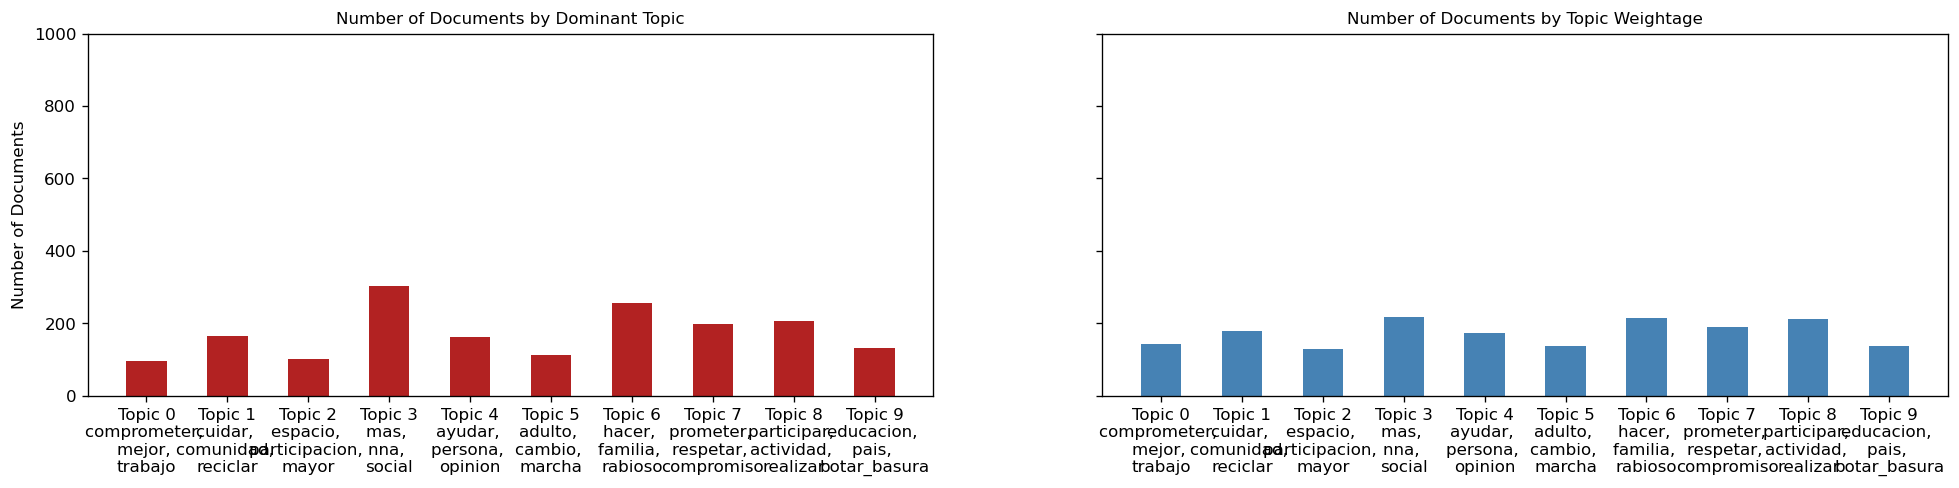

In [41]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()


In [42]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 945 samples in 0.001s...
[t-SNE] Computed neighbors for 945 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 945 / 945
[t-SNE] Mean sigma: 0.001408
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.110149
[t-SNE] KL divergence after 1000 iterations: 0.314897


Loading BokehJS ...

# Seleccionar por coherencia

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3, a=0.01, b=0.1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
#        model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, 
#                                                num_topics=num_topics, random_state=100,alpha=a,eta=b,
#                                                chunksize=100,passes=10, per_word_topics=True)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=num_topics, random_state=100,update_every=1,chunksize=128,passes=10,alpha='auto',eta='auto',per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=30, step=1)

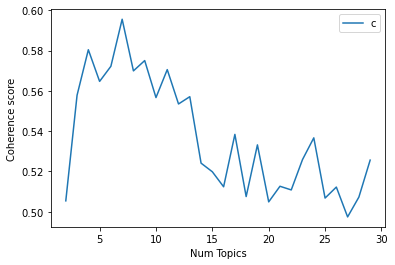

In [17]:
# Show graph
limit=30; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

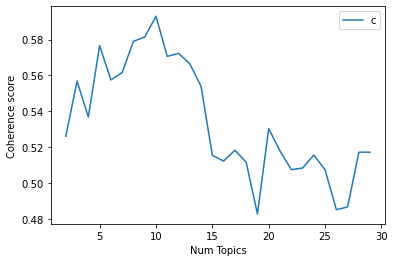

In [24]:
# Show graph
limit=30; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()